<p style="font-family: Arial; font-size:3em;color:purple; font-style:bold"><br>
INFS 768 Group Project </p>
<p style="font-family: Arial; font-size:2em; font-style:bold">
<br> Kyle Downs, Cara, Bracken, Rylie Fleckenstein<br><br> </p>
<p style="font-family: Arial; font-size:1.5em; color:#2462C0; font-style:bold">
Building ML Models to Determine if an App is Free or not</p>

## Predictions with the Google Play Data Set

### Outline

- Data Processing

- Feature Selection

- Hyperparameter tuning and model selection


## Data Analysis

### GooglePlay Data Set

We are creating a model to predict the type of an App (whether it is free or requires payment). 

### About this dataset

"Context: While many public datasets (on Kaggle and the like) provide Apple App Store data, there are not many counterpart datasets available for Google Play Store apps anywhere on the web. On digging deeper, I found out that iTunes App Store page deploys a nicely indexed appendix-like structure to allow for simple and easy web scraping. On the other hand, Google Play Store uses sophisticated modern-day techniques (like dynamic page load) using JQuery making scraping more challenging."

"Acknowledgements: This information is scraped from the Google Play Store. This app information would not be available without it."

The data set : https://www.kaggle.com/lava18/google-play-store-apps

### Feature Information

1) App - name of the application

2) Category - category the application falls in

3) Rating - the average rating given for the application

4) Reviews - how many reviews have been written for the app

5) Size - how large of a file it is in megabytes and kilobytes

6) Installs - how many times the app has been installed

7) Type - if the app is free of paid (target)

8) Price - how much the app costs 

9) Content Rating - what age group the app is targeted for

10) Genres - what genre the app falls in (similar to category)

11) Last Updated - date of most recent update

12) Current Ver - what version of the app the deveopers are currently on for IOS

13) Android Ver - what version of the app the deveopers are currently on for Android

In [1]:
import numpy as np 
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [2]:
# Load google play csv file into pandas dataframe
gp_dat = pd.read_csv("googleplaystore.csv")
gp_dat.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Data Preprocessing


The below code prints description of all categorical attributes. We used this in the preprocessing stage to take a look and see what we were working with in order gain an understanding of the nature of all of the categorical variables. I commented out this block of code to save space in the final document but it is still here for use whenever it is needed.

In [3]:
# description of every categorical attribute
# Rylie's code
#df_ = gp_dat.select_dtypes(exclude=['int64', 'float64'])
#for col in df_.columns:
    #print(df_[col].unique()) # to print categories name only
    #print(df_[col].value_counts()) # to print count of every category

### Missing Values

The first step is to take a look and see if we have any missing values in the data set that need to be taken care of. We can see that "Rating" is missing 1474 observations and then "Content Rating", "Type", "Current Ver" and "Android Ver" are all missing just a few observations. We decided to go ahead and drop the observations that had only a few missing values and decided to replace all of the missing values in "Rating" with the mean of "Rating".

In [4]:
gp_dat.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [5]:
# Kyle's code
gp_dat = gp_dat.dropna(subset = ['Content Rating','Type', 'Current Ver', 'Android Ver'])

Whenever the decision is made to replace a missing value with some other value, it is important to indicate that the replacement. This is because even though we are taking the mean of the variable in question, this value is more than likely wrong. We have no way of knowing what the actual value would be, but instead use the mean of the variable to ensure we do not change its distribution. Below we create a missing value indicator for the "Rating" attribute.

In [6]:
# create new variable (missing value indicator for Rating)
# Rylie's code
gp_dat['Rating_Miss_Ind']=np.select([gp_dat.Rating.isnull()],[1])
gp_dat.Rating_Miss_Ind.value_counts()

0    9360
1    1469
Name: Rating_Miss_Ind, dtype: int64

Replacing the missing values with the mean

In [7]:
# Replace NaN values for Rating with the mean of Rating
# Kyle's code
gp_dat['Rating'] = gp_dat['Rating'].fillna(gp_dat['Rating'].mean())

Changing the data type of the "Rating" attribute to "int64" so it can be used in our ML models.

In [8]:
# Kyle's code
gp_dat['Reviews'] = gp_dat['Reviews'].astype('int64')

Checking to make sure we have taken care of all missing values

In [9]:
gp_dat.isnull().sum()

App                0
Category           0
Rating             0
Reviews            0
Size               0
Installs           0
Type               0
Price              0
Content Rating     0
Genres             0
Last Updated       0
Current Ver        0
Android Ver        0
Rating_Miss_Ind    0
dtype: int64

## Attribute tansformations

Most of the variables in this dataset are not ready to be ran through a ML algorithm and must be converted and processed so we can build a succesfful model

### "Type"
Here we are changing the binary variable "Type" to numbers Free:0, and Paid:1.

In [10]:
# changing TYPE to 0 if free and 1 if paid
# Rylie's code
gp_dat['Type'] = gp_dat['Type'].replace({'Free': 0, 'Paid': 1}, regex=True).astype(float)


### "Price"

Here we stripped the "Price" variable of all special characters and then converted it to data type "float"

In [11]:
# changing currency to integer in PRICE
gp_dat['Price'] = gp_dat['Price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

### "Size"

Dealing with the "Size" attribute was tricky. There are instances that are in Megabytes indicated by an "M" at the end of the value and also instances in kilobytes indicated by a "k", instances that have decimals in them and instances labeled as "varies with device". The original data type of this variable is also a string so coming up with a clear solution to convert all instances to the same scale (Megabytes) and remove all special characters was not particularly straight forward.

Rylie decided to create a kilobyte indicator column so that he could remove the special characters from each instance and transform each instance into integers. Then he was able to divide all of the instances of the "Size" variable that had the kilobyte indicator by 1000 so that all of the sizes were in Megabytes. Then he set all instances of "varies with device" to NaN and replaced them with the mean.

In [12]:
# setting indicator for Kilobytes
gp_dat['Size_K']=np.select([gp_dat.Size.str.contains('k')],[1])

In [13]:
gp_dat['Size_K'].value_counts()

0    10517
1      312
Name: Size_K, dtype: int64

In [14]:
# set 'Varies with device' as NA and removing all special characters
gp_dat['Size'] = gp_dat['Size'].replace({'Varies with device': np.NaN, 'M' : '', 'k': ''}, regex=True).astype(float)

In [15]:
# Varies with device value indicator for SIZE
gp_dat['Size_Varies_Ind']=np.select([gp_dat.Size.isnull()],[1])
gp_dat.Size_Varies_Ind.value_counts()

0    9135
1    1694
Name: Size_Varies_Ind, dtype: int64

In [16]:
# converting all Kilobyte instances to Megaabytes
gp_dat.loc[gp_dat['Size_K'] == 1, 'Size'] = gp_dat['Size']/1000

In [17]:
# Replacing all "Varies with Device" with mean in Megaabytes
gp_dat['Size'] = gp_dat['Size'].fillna(gp_dat['Size'].mean())

In [18]:
# dropping kilobyte indicator
gp_dat = gp_dat.drop(['Size_K'], axis=1)

In [19]:
gp_dat.Size.describe()

count    10829.000000
mean        21.534957
std         20.751190
min          0.008500
25%          5.900000
50%         18.000000
75%         26.000000
max        100.000000
Name: Size, dtype: float64

### "Installs"

Here we stripped all instances of special characters and changed the data type to float.

In [20]:
gp_dat['Installs'] = gp_dat['Installs'].map(lambda x: x.rstrip('+-'))

In [21]:
gp_dat['Installs'] = gp_dat['Installs'].replace({',': ''}, regex=True).astype(float)

### "Last Updated"

Here we decided to drop the specific day the update took place and only keep the year the app was updated. This was done using the thought process that we could then categorize our apps by what year they were updated, making "Last Updated" a categorical variable.

In [22]:
# changing last updated to just the year for grouping
gp_dat['Last Updated'] = gp_dat['Last Updated'].apply(lambda x: x[-4:])


In [23]:
gp_dat['Last Updated'] = gp_dat['Last Updated'].astype(float)

### Dummy Encoding

Here we use the get_dummies() function to dummy encode all of our categorical variables which are the following: ["Category","Last Updated", "Content Rating"].


In [24]:
# generate binary values using get_dummies
gp_dat = pd.get_dummies(gp_dat, columns=["Category","Last Updated", "Content Rating"])

In [25]:
gp_dat.head()

,App,Rating,Reviews,Size,Installs,Type,Price,Genres,Current Ver,Android Ver,...,Last Updated_2015.0,Last Updated_2016.0,Last Updated_2017.0,Last Updated_2018.0,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
0,Photo Editor & Candy Camera & Grid & ScrapBook,4.1,159,19.0,10000.0,0.0,0.0,Art & Design,1.0.0,4.0.3 and up,...,0,0,0,1,0,1,0,0,0,0
1,Coloring book moana,3.9,967,14.0,500000.0,0.0,0.0,Art & Design;Pretend Play,2.0.0,4.0.3 and up,...,0,0,0,1,0,1,0,0,0,0
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",4.7,87510,8.7,5000000.0,0.0,0.0,Art & Design,1.2.4,4.0.3 and up,...,0,0,0,1,0,1,0,0,0,0
3,Sketch - Draw & Paint,4.5,215644,25.0,50000000.0,0.0,0.0,Art & Design,Varies with device,4.2 and up,...,0,0,0,1,0,0,0,0,1,0
4,Pixel Draw - Number Art Coloring Book,4.3,967,2.8,100000.0,0.0,0.0,Art & Design;Creativity,1.1,4.4 and up,...,0,0,0,1,0,1,0,0,0,0


### Feature Selection

Drop the "Price" variable because it is positively coorelated with the target variable "Type". The variable "Type" is actually derived from the "Price" variable. Also, we drop the "Genres" model because it is positively correlated to the "Category" variable. Lastly, we drop the "App", "Android Ver", and "Genres" variables because they are not variable because the name of the application is not relevant or needed in the ML model as well as what version they are on.

In [26]:
gp_dat = gp_dat.drop(['App', 'Current Ver', 'Android Ver', 'Genres'], axis=1)

In [27]:
gp_dat = gp_dat.drop(['Price'], axis=1)

## Random Sampling/ Known Sampling

The intial approach to dealing with this unbalanced classification problem was to take a random sample of the instances where the app was of "Type" Free so that the classes of the target variable were equal and not skewed. Skewed classes in the target variable do not perform well in machine learning algorithms. This approach seemed to work alright but we ended up changing it after some experimentation. We started to experiment with known sampling and settled on using the first 800 observations of the FREE class in the target variable because we were able to produce models that performed extremely well.

In [28]:
gp_dat['Type'].value_counts()

0.0    10032
1.0      797
Name: Type, dtype: int64

Subsetting the data set based on the class of the target variable "Type"

In [29]:
gp_dat_paid = gp_dat[gp_dat['Type'] == 1]
gp_dat_free = gp_dat[gp_dat['Type'] == 0]

In [30]:
gp_dat_paid.shape

(797, 55)

In [31]:
gp_dat_free.shape

(10032, 55)

Using the first 800 observations of the FREE subset for use in our final data set

In [32]:
#gp_dat_free_f = gp_dat_free.sample(800, random_state=5)
gp_dat_free_f = gp_dat_free[:800]
gp_dat_free_f.shape

(800, 55)

In [33]:
gp_dat2 = pd.concat([gp_dat_paid, gp_dat_free_f])

Showing the counts of the classes in the target variable

In [34]:
# y includes our labels and x includes our features
dlist = ['Type']
x1 = gp_dat.drop(dlist, axis=1)
y1 = gp_dat['Type']

In [35]:
#actual learning data set where equal target values
dlist = ['Type']
x = gp_dat2.drop(dlist, axis=1)
y = gp_dat2['Type']

The original dataset class distribution

Number of Paid:  797
Number of Free:  10032


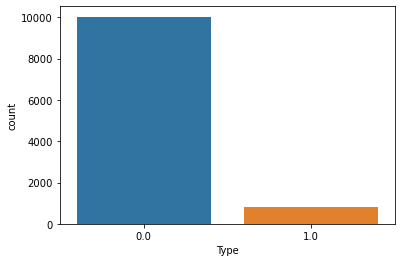

In [36]:
# class break down of the target attribute in the full dataset
ax = sns.countplot(y1,label="Count")       
F, P = y1.value_counts()                   # 0 if Free 1 if paid
print('Number of Paid: ',P)
print('Number of Free: ',F)

The class distribution of the data set we used for building our models

Number of Paid:  797
Number of Free:  800


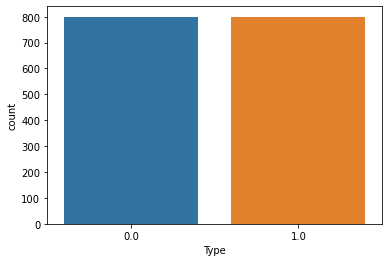

In [37]:
# class break down of the target attribute in the subset used for the predictions
ax = sns.countplot(y,label="Count")       
F, P = y.value_counts()                   # 0 if Free 1 if paid
print('Number of Paid: ',P)
print('Number of Free: ',F)

## Predicting the Type




In [38]:
#split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

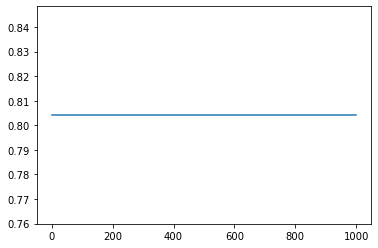

In [39]:
# hyperparameter tuning Logistic Regression Classifier

scores = []

for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    clf_lr = LogisticRegression(C=C, solver='lbfgs')
    
    clf_lr.fit(x_train, y_train)
    y_pred = clf_lr.predict(x_test)
    scores.append(accuracy_score(y_test,y_pred))
#print(scores)    
plt.plot([0.001, 0.01, 0.1, 1, 10, 100, 1000], scores)
plt.show()

Train accuracy is:  0.8290062667860341
Test accuracy is:  0.8041666666666667


<AxesSubplot:>

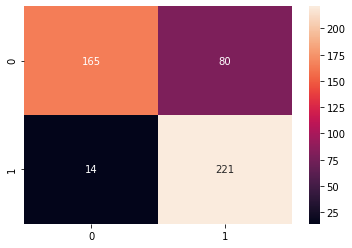

In [40]:
# Logistic Regression Classifier

clf_lr = LogisticRegression(C=1e5, solver='lbfgs')
    
clf_lr.fit(x_train, y_train)
y_pred = clf_lr.predict(x_test)

actrain = accuracy_score(y_train,clf_lr.predict(x_train))
print('Train accuracy is: ',actrain)
    
ac = accuracy_score(y_test,clf_lr.predict(x_test))
print('Test accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_lr.predict(x_test))

#prec = precision_score(y_test,clf_lr.predict(x_test))
#print('Precision score is: ',prec)

#rec = recall_score(y_test,clf_lr.predict(x_test))
#print('Recall score is: ',rec)

sns.heatmap(cm,annot=True,fmt="d")

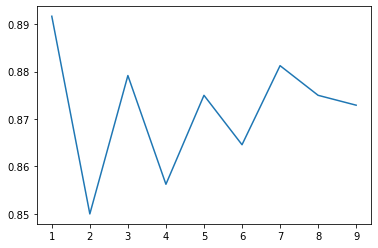

In [41]:
# hyperparameter tuning of K Nearest Neighbors Classifier

scores = []

for neighbors in range(1,10):
    clf_nn = KNeighborsClassifier(n_neighbors=neighbors, metric='minkowski')
    
    clf_nn.fit(x_train, y_train)
    y_pred = clf_nn.predict(x_test)
    scores.append(accuracy_score(y_test,y_pred))
#print(scores)    
plt.plot(list(range(1,10)), scores)
plt.show()

Train accuracy is:  1.0
Test accuracy is:  0.8916666666666667


<AxesSubplot:>

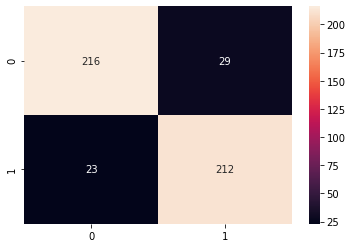

In [42]:
# KNN classifier

clf_nn = KNeighborsClassifier(n_neighbors=1, metric='minkowski')
    
clf_nn.fit(x_train, y_train)
y_pred = clf_nn.predict(x_test)


actrain = accuracy_score(y_train,clf_nn.predict(x_train))
print('Train accuracy is: ',actrain)
ac = accuracy_score(y_test,clf_nn.predict(x_test))
print('Test accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_nn.predict(x_test))

#prec = precision_score(y_test,clf_nn.predict(x_test))
#print('Precision score is: ',prec)

#rec = recall_score(y_test,clf_nn.predict(x_test))
#print('Recall score is: ',rec)

sns.heatmap(cm,annot=True,fmt="d")


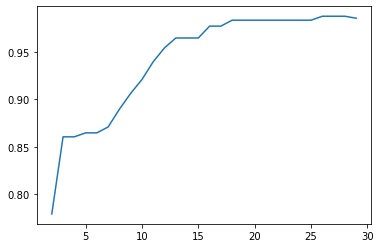

In [43]:
# hyperparameter tuning of Decision Tree Classifier
scores = []

for leaves in range(2,30):
    clf_dt = DecisionTreeClassifier(max_leaf_nodes=leaves, random_state=0,
                                   criterion='entropy')
    clf_dt.fit(x_train,y_train)
    y_pred = clf_dt.predict(x_test)
    
    scores.append(accuracy_score(y_test,y_pred))
#print(scores)
plt.plot(list(range(2,30)), scores)
plt.show()

Train accuracy is:  0.9955237242614146
Test accuracy is:  0.9854166666666667


<AxesSubplot:>

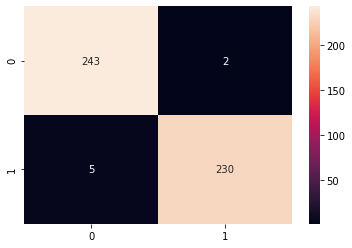

In [44]:
# Decision Tree Classifier
clf_dt = DecisionTreeClassifier(max_leaf_nodes=29, random_state=0,
                                   criterion='entropy')
clf_dt.fit(x_train,y_train)
y_pred = clf_dt.predict(x_test)

actrain = accuracy_score(y_train,clf_dt.predict(x_train))
print('Train accuracy is: ',actrain)
    
ac = accuracy_score(y_test,clf_dt.predict(x_test))
print('Test accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_dt.predict(x_test))

#prec = precision_score(y_test,clf_dt.predict(x_test))
#print('Precision score is: ',prec)

#rec = recall_score(y_test,clf_dt.predict(x_test))
#print('Recall score is: ',rec)

sns.heatmap(cm,annot=True,fmt="d")



### Visualize the Decision Tree

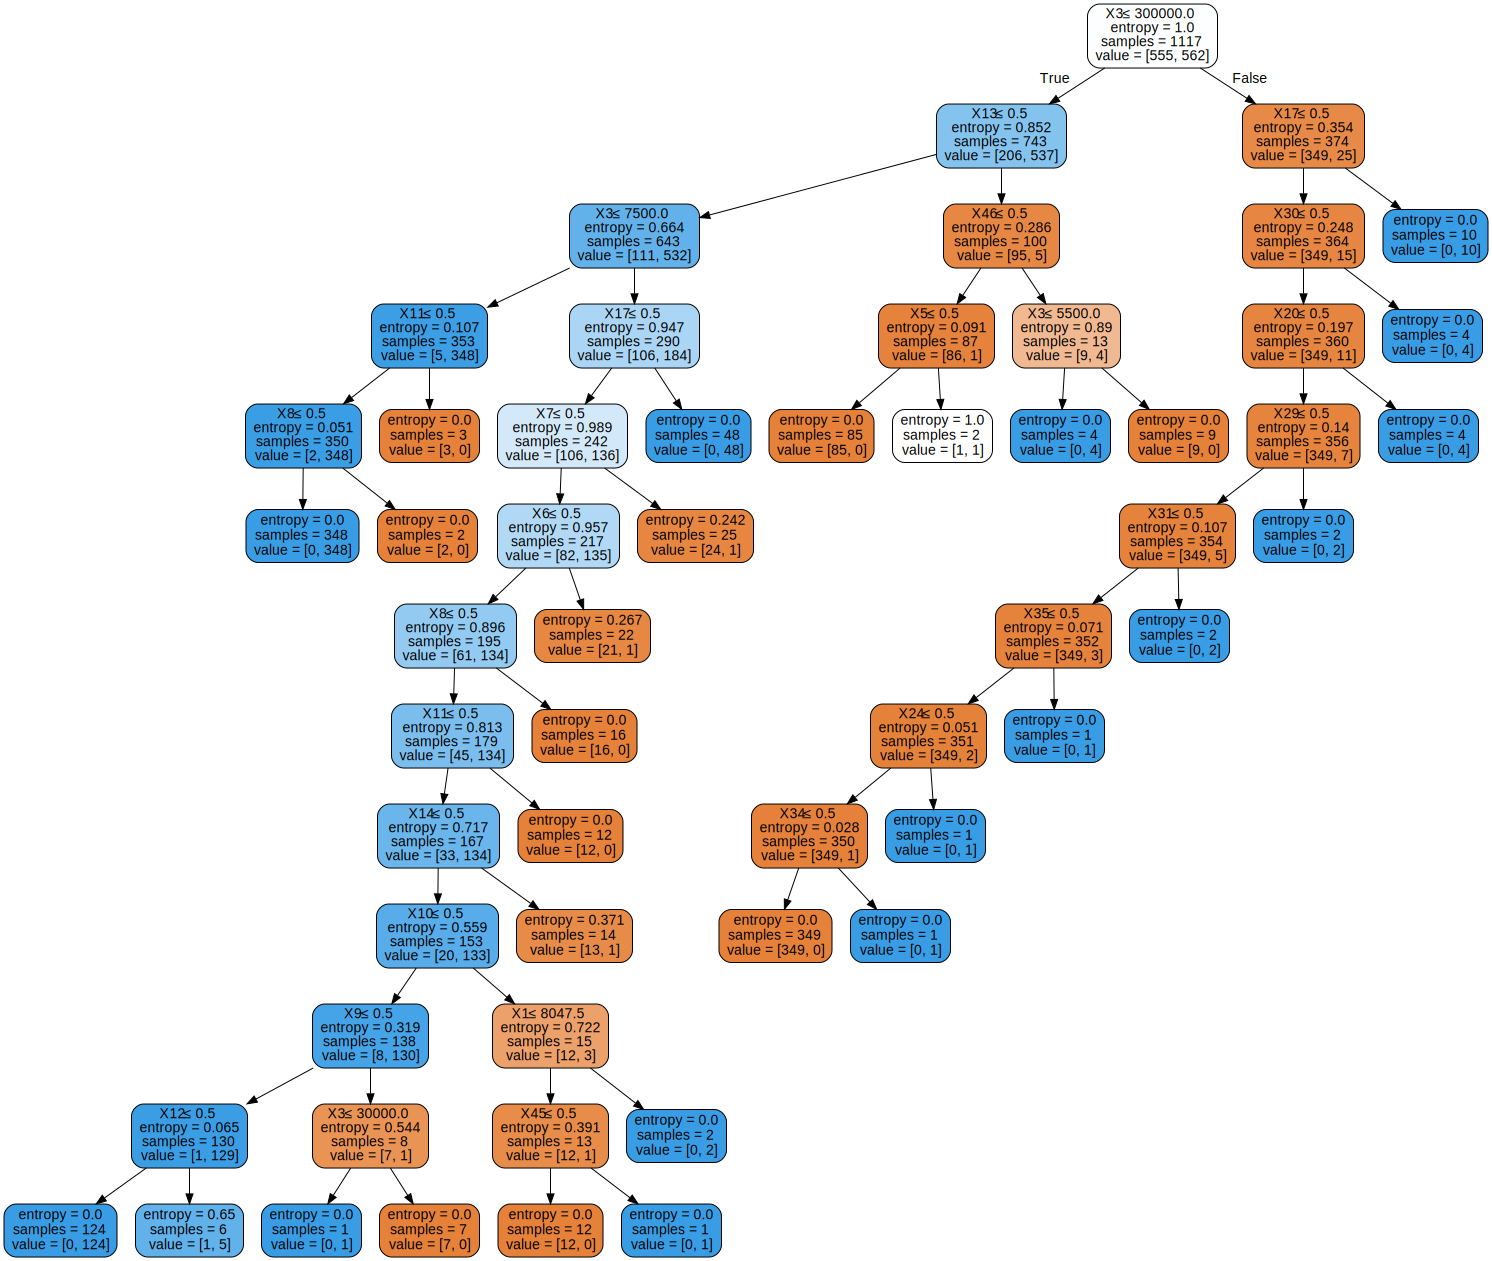

In [45]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(clf_dt, out_file=None, 
                        filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Model Selection

The Decision Tree model we built performs extremely well with 98.5% accuracy and is the one we decided to go with as our final model.